In [10]:
from model import *
from train_test_split import *
from predictionsGraph import *
from data_set import *
from torch.utils.data import DataLoader
from scipy.stats import spearmanr

In [11]:
seq_len = 3 #ovdje treba biti ista vrijednost kao kad se treniralo
batch_size = 1 #
hidden_dim = 512
#hidden_dim2 = 1024
attention = True
target='PRAM'
nr_days = 1

In [12]:
train_data, val_data, test_data = load_data('real_for_all_podaci_novo.csv', 'lognormalize', target) 
input_dim = train_data.shape[1]
train_dataset = Dataset(train_data, seq_len, nr_days, target)
val_dataset = Dataset(val_data, seq_len, nr_days, target)
test_dataset = Dataset(test_data, seq_len, nr_days, target)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
#model = Net(input_dim,  hidden_dim = hidden_dim, hidden_dim2 = hidden_dim2, seq_len=seq_len, nr_days=nr_days, attention=attention)
model = Net(input_dim,  hidden_dim = hidden_dim, seq_len=seq_len, nr_days=nr_days, attention=attention)

In [13]:
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-lr_0.01-hidd_dim_128-hidd_dim2_1024-att_{attention}_best.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-lr_0.01-hidd_dim_128-hidd_dim2_128-att_{attention}_best.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-lr_0.007-hidd_dim_128-hidd_dim2_1024-att_{attention}_best.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-lr_0.005-hidd_dim_128-hidd_dim2_1024-att_{attention}_best.weights'

path_to_model = f'models/PRBR/batch_size_128-seq_len_3-lr_0.005-hidd_dim_32-hidd_dim2_1024-att_{attention}_best.weights'
path_to_model = f'models/PRBR/batch_size_128-seq_len_3-lr_0.01-hidd_dim_32-hidd_dim2_1024-att_{attention}_best.weights'

path_to_model = f'models/PRTR/batch_size_128-seq_len_3-lr_0.007-hidd_dim_16-hidd_dim2_128-att_{attention}_best.weights'
path_to_model = f'models/PRTR/batch_size_128-seq_len_3-lr_0.005-hidd_dim_16-hidd_dim2_128-att_{attention}_best.weights'

path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_2-lr_0.005-hidd_dim_128-hidd_dim2_1024-att_{attention}_best.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_3-lr_0.005-hidd_dim_128-hidd_dim2_1024-att_{attention}_best.weights'

path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_2-lr_0.005-hidd_dim_128-hidd_dim2_1024-att_{attention}_best_probaMeteo.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_1-lr_0.005-hidd_dim_128-hidd_dim2_1024-att_{attention}_best_probaMeteo.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_1-lr_0.005-hidd_dim_256-hidd_dim2_1024-att_{attention}_best_probaMeteo.weights'

path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_1-lr_0.005-hidd_dim_512-hidd_dim2_1024-att_{attention}_best_meteo.weights'
path_to_model = f'models/PRAM/batch_size_32-seq_len_3-nr_days_1-lr_0.005-hidd_dim_512-att_{attention}_best_meteo.weights'
path_to_model = f'models/PRAM/batch_size_1-seq_len_3-nr_days_1-lr_0.005-hidd_dim_512-att_{attention}_best_meteo.weights'
model.load_state_dict(torch.load(path_to_model))
model.eval()

Net(
  (lstm): LSTM(7, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (lstm_cell): LSTMCell(6, 512)
  (sigmoid): Sigmoid()
  (attention): Attention(
    (v): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [14]:
def calculateMean(targ='PRAM', locations=['NS'], test_years=[2015, 2016], valid_years=None):
    #targ = targ
    data = pd.read_csv('real_for_all_podaci_novo.csv')
    data = data[[targ, 'GOD', 'LOK']]
    trainvalid_dataset_pom, test_dataset_pom = train_test_split(data, targ, locations = locations, test_years=test_years)
    if valid_years is not None:
        trainvalid_dataset_pom, test_dataset_pom = train_test_split(data, targ, locations = locations, test_years=valid_years)
    MEAN = trainvalid_dataset_pom[targ].mean()
    return MEAN

def returnTensorToStartingValues(t, mean):
    return (torch.exp(t)-1)*mean

MEAN = calculateMean(targ=target, locations=['NS'], test_years=[2015, 2016], valid_years=[2013,2014])

In [15]:
realValues = []
predictedValues = []
for dan in range(nr_days):
    realValues.append([])
    predictedValues.append([])
model.to('cuda')

for (inputs, meteo, labels) in test_loader:
    inputs, meteo, labels = inputs.to('cuda'), meteo.to('cuda'), labels.to('cuda')
    output = model(inputs, meteo)#, h)
    for dan in range(nr_days):
        realValues[dan].append(labels[0][dan].item())
        predictedValues[dan].append(output[0][dan].item())

for dan in range(nr_days):
    realValues[dan] = torch.FloatTensor(realValues[dan])
    predictedValues[dan]= torch.FloatTensor(predictedValues[dan])
    realValues[dan] = returnTensorToStartingValues(realValues[dan],MEAN)
    predictedValues[dan] = returnTensorToStartingValues(predictedValues[dan],MEAN)

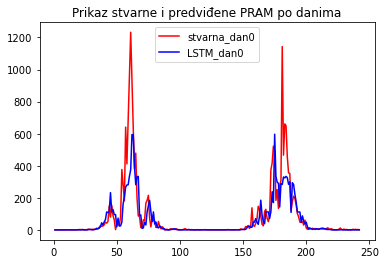

DAN 0  loss LSTM: tensor(116.9037) loss pattern: tensor(130.5429)


In [16]:
if target=='PRAM':
    naziv='ambrozija'
if target=='PRBR':
    naziv='breza'
if target=='PRTR':
    naziv='trave'
podaciZaCrtanje = pd.read_csv(naziv+'_NoviSad_patternPredictions.csv')
podaciZaCrtanje = podaciZaCrtanje.sort_values(by=['DAT'])
#print(podaciZaCrtanje)
staraPredvidjenaVrijednost = []
for i in range(len(podaciZaCrtanje)):
    staraPredvidjenaVrijednost.append(podaciZaCrtanje.iloc[i].predvidjenaVrijednost)
staraPredvidjenaVrijednost = staraPredvidjenaVrijednost[seq_len:-1*nr_days] #jer za prva 3 dana LSTM ne predvidja (tako su napravljeni podaci)
#predictionsGraph([realValues, predictedValues, staraPredvidjenaVrijednost], ['stvarna', 'LSTM', 'patterns'],target)
#predictionsGraphScatter([realValues, predictedValues, staraPredvidjenaVrijednost], ['stvarna', 'LSTM', 'patterns'],target)
for dan in range(nr_days):
    predictionsGraph([realValues[dan], predictedValues[dan]], ['stvarna_dan'+str(dan), 'LSTM_dan'+str(dan)],target)

loss_fn = nn.MSELoss(reduction='mean')
for dan in range(nr_days):
    loss1 = np.sqrt(loss_fn(realValues[dan], predictedValues[dan]))
    loss2 = np.sqrt(loss_fn(realValues[dan], torch.FloatTensor(staraPredvidjenaVrijednost)))
    print('DAN',dan,' loss LSTM:',loss1,'loss pattern:',loss2)

In [17]:
#def returnToStartingValues(value, mean):
#    return (np.e**value-1)*mean
#aero2020 = pd.read_csv(f'aero2020_predictions/test_{target.lower()}_lag=3_pred.csv', header = 0)
#aero2020 = aero2020.iloc[seq_len-1:,:].reset_index()
#aero2020_predicted = list(map(lambda x: float(x), list(aero2020['Neural Network'])))
#aero2020_predicted = list(map(lambda x: returnToStartingValues(x,MEAN),aero2020_predicted))
#predictionsGraph([realValues, predictedValues, aero2020_predicted], ['stvarna', 'LSTM', 'aero2020'], target)
#loss1 = np.sqrt(loss_fn(realValues, predictedValues))
#loss2 = np.sqrt(loss_fn(realValues, torch.FloatTensor(aero2020_predicted)))
#print('loss LSTM:',loss1,'loss aero2020:',loss2)

FileNotFoundError: [Errno 2] No such file or directory: 'aero2020_predictions/test_pram_lag=3_pred.csv'

In [18]:
spearman_LSTM = spearmanr(realValues[0], predictedValues[0])
spearman_pattern = spearmanr(realValues[0], staraPredvidjenaVrijednost)
#spearman_aero2020 = spearmanr(realValues, aero2020_predicted)
spearman_aero2020 = 0.0

print(f"Spearman's coefficient: \n\t LSTM = {spearman_LSTM} \n \t pattern = {spearman_pattern}, \n \t aero2020 = {spearman_aero2020}")

Spearman's coefficient: 
	 LSTM = SpearmanrResult(correlation=0.9034085965764367, pvalue=3.101378739881027e-90) 
 	 pattern = SpearmanrResult(correlation=0.8860445738913761, pvalue=4.3438215187921604e-82), 
 	 aero2020 = 0.0
